# 0 Imports

In [1]:
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import nltk

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

np.random.seed(0)


***
# 1 Config

In [2]:
config = {
    "bag": False,
    "tfidf": False,
    "unsupervised": False,
    "supervised": True
}

***
# 2 Data Loading

In [3]:
data = pd.read_csv("data/data_cleaned.csv", index_col="Id")

data["Tags"] = data["Tags"].apply(eval)
# data["Tokens"] = data["Tokens"].apply(eval)
# data["POS"] = data["POS"].apply(eval)
# data["Lemmatized"] = data["Lemmatized"].apply(eval)
# data["LemmaAndStem"] = data["LemmaAndStem"].apply(eval)

In [4]:
data.head()

,Title,Body,Tags,Tokens,POS,Lemmatized,LemmaAndStem,Sentence
Id,,,,,,,,
4,how to convert a decimal to a double in c#?,i want to use a to change a 's opacity.\nthis is my code:\n\nwhen i build the application it gives the following error:\n\n\n\ni have tried using and but then the doesn't work. this code worked fine in a past vb.net project.\n,"[c#, floating-point, type-conversion, double, decimal]","['want', 'use', 'change', 'opacity', 'code', 'build', 'application', 'gives', 'following', 'error', 'tried', 'using', 'work', 'code', 'worked', 'fine', 'past', 'vb', '.net', 'project', 'convert', 'decimal', 'double', 'c#']","[('want', 'n'), ('use', 'n'), ('change', 'n'), ('opacity', 'n'), ('code', 'n'), ('build', 'a'), ('application', 'n'), ('gives', 'v'), ('following', 'v'), ('error', 'n'), ('tried', 'v'), ('using', 'v'), ('work', 'n'), ('code', 'n'), ('worked', 'v'), ('fine', 'a'), ('past', 'n'), ('vb', 'a'), ('.net', 'n'), ('project', 'n'), ('convert', 'v'), ('decimal', 'a'), ('double', 'a'), ('c#', 'n')]","['want', 'use', 'change', 'opacity', 'code', 'build', 'application', 'give', 'follow', 'error', 'try', 'use', 'work', 'code', 'work', 'fine', 'past', 'vb', '.net', 'project', 'convert', 'decimal', 'double', 'c#']","['want', 'use', 'chang', 'opac', 'code', 'build', 'applic', 'give', 'follow', 'error', 'tri', 'use', 'work', 'code', 'work', 'fine', 'past', 'vb', '.net', 'project', 'convert', 'decim', 'doubl', 'c#']",want use chang opac code build applic give follow error tri use work code work fine past vb .net project convert decim doubl c#
6,why did the width collapse in the percentage width child element in an absolutely positioned parent on internet explorer 7?,i have an absolutely positioned containing several children one of which is a relatively positioned . when i use a on the child it collapses to on ie7 but not on firefox or safari.\nif i use it works. if the parent is relatively positioned the percentage width on the child works.\n\nis there something i'm missing here?\nis there an easy fix for this besides the on the child?\nis there an area of the css specification that covers this?\n\n,"[html, css, internet-explorer-7]","['absolutely', 'positioned', 'containing', 'several', 'children', 'one', 'relatively', 'positioned', 'use', 'child', 'collapses', 'ie', 'firefox', 'safari', 'use', 'works', 'parent', 'relatively', 'positioned', 'percentage', 'width', 'child', 'works', 'something', 'missing', 'easy', 'fix', 'besides', 'child', 'area', 'css', 'specification', 'covers', 'width', 'collapse', 'percentage', 'width', 'child', 'element', 'absolutely', 'positioned', 'parent', 'internet', 'explorer']","[('absolutely', 'r'), ('positioned', 'v'), ('containing', 'v'), ('several', 'a'), ('children', 'n'), ('one', 'n'), ('relatively', 'r'), ('positioned', 'v'), ('use', 'n'), ('child', 'n'), ('collapses', 'n'), ('ie', 'v'), ('firefox', 'n'), ('safari', 'n'), ('use', 'n'), ('works', 'v'), ('parent', 'n'), ('relatively', 'r'), ('positioned', 'v'), ('percentage', 'n'), ('width', 'n'), ('child', 'n'), ('works', 'v'), ('something', 'n'), ('missing', 'v'), ('easy', 'a'), ('fix', 'a'), ('besides', 'n'), ('child', 'a'), ('area', 'n'), ('css', 'n'), ('specification', 'n'), ('covers', 'v'), ('width', 'a'), ('collapse', 'n'), ('percentage', 'n'), ('width', 'n'), ('child', 'n'), ('element', 'n'), ('absolutely', 'r'), ('positioned', 'v'), ('parent', 'a'), ('internet', 'n'), ('explorer', 'n')]","['absolutely', 'position', 'contain', 'several', 'child', 'one', 'relatively', 'position', 'use', 'child', 'collapse', 'ie', 'firefox', 'safari', 'use', 'work', 'parent', 'relatively', 'position', 'percentage', 'width', 'child', 'work', 'something', 'miss', 'easy', 'fix', 'besides', 'child', 'area', 'cs', 'specification', 'cover', 'width', 'collapse', 'percentage', 'width', 'child', 'element', 'absolutely', 'position', 'parent', 'internet', 'explorer']","['absolut', 'posit', 'contain', 'sever', 'children', 'one', 'relat', 'posit', 'use', 'child', 'colla

***
# 3 Tags

In [5]:
data[["Tags"]].head()

,Tags
Id,
4,"[c#, floating-point, type-conversion, double, decimal]"
6,"[html, css, internet-explorer-7]"
9,"[c#, .net, datetime]"
11,"[c#, datetime, time, datediff, relative-time-span]"
13,"[html, browser, timezone, user-agent, timezone-offset]"


In [6]:
data.Tags.values

array([list(['c#', 'floating-point', 'type-conversion', 'double', 'decimal']),
       list(['html', 'css', 'internet-explorer-7']),
       list(['c#', '.net', 'datetime']), ...,
       list(['css', 'xhtml', 'refactoring']),
       list(['python', 'class', 'anonymous-class']),
       list(['c', 'linux', 'file', 'io', 'std'])], dtype=object)

In [7]:
tags = []
for row in data.Tags.values:
    tags += row
tags_df = pd.DataFrame(data=tags, columns=["Tag"]).value_counts().reset_index()
tags_df.columns = ["Tag", "Count"]

In [8]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9252 entries, 0 to 9251
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tag     9252 non-null   object
 1   Count   9252 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 144.7+ KB


In [9]:
tags_df.head()

,Tag,Count
0,c#,6448
1,.net,5174
2,java,3758
3,asp.net,3261
4,c++,2691


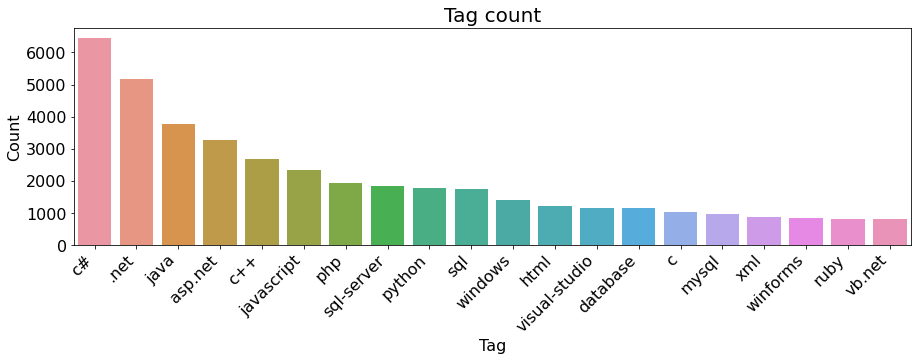

In [10]:
plt.figure(figsize=(15, 4))

sns.barplot(data=tags_df.iloc[:20], x="Tag", y="Count")

plt.title("Tag count", size=20)
plt.xlabel("Tag", size=16)
plt.ylabel("Count", size=16)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

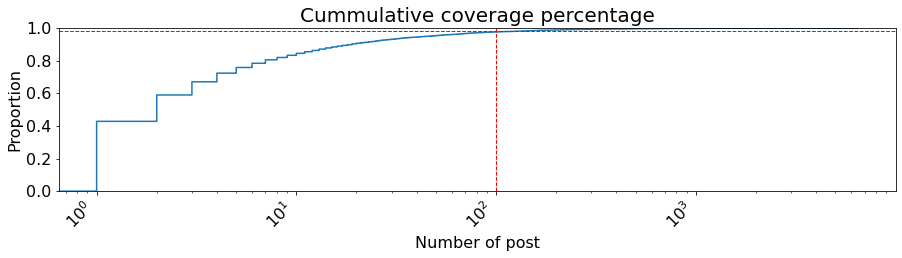

In [11]:
plt.figure(figsize=(15, 3))

ax = sns.ecdfplot(data=tags_df, x="Count", log_scale=True)

plt.axhline(0.98, linestyle="--", linewidth=1, color="r")
plt.axvline(100, linestyle="--", linewidth=1, color="r")

plt.title("Cummulative coverage percentage", size=20)
plt.xlabel("Number of post", size=16)
plt.ylabel("Proportion", size=16)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

In [12]:
tags_df = tags_df[:100]
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tag     100 non-null    object
 1   Count   100 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


In [13]:
tags = tags_df.Tag

***
# 4 Bag-Of-Words

In [ ]:
def bow(dataset, max_features=None, min_df=0.0, max_df=1.0):
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, max_features=max_features, max_df=max_df, min_df=min_df)
    matrix = vectorizer.fit_transform(dataset).toarray()
    vocab = vectorizer.get_feature_names_out()
    bag = pd.DataFrame(data=matrix, columns=vocab)
    return bag

In [ ]:
display = None
if config["bag"]:
    bag = bow(data, "Sentence")
    display = bag.iloc[:5, :20]
display

***
# 5 TF-IDF

In [ ]:
def tfidf(dataset, max_features=None, min_df=0.0, max_df=1.0):
    vectorizer = TfidfVectorizer(tokenizer=None, stop_words=None, max_features=max_features, min_df=min_df, max_df=max_df)
    matrix = vectorizer.fit_transform(dataset).toarray()
    vocab = vectorizer.get_feature_names_out()
    tfidf = pd.DataFrame(data=matrix, columns=vocab)
    return tfidf

In [ ]:
display = None
if config["tfidf"]:
    tfidf = tfidf(data, "Sentence")
    display = tfidf.iloc[:5, :20]
display

***
# 6 Unsupervised

## 6.0 Utils

In [ ]:
def latent_dirichlet_allocation(dataset: pd.DataFrame, n_topics: int, max_iter=5, learning_offset=50, max_features=None):
    feature_names = dataset.columns

    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=max_iter, learning_method="online", learning_offset=learning_offset, random_state=0)
    lda.fit(data)
    return lda, feature_names

In [ ]:
# https://blog.mlreview.com/topic-modeling-with-scikit-learn-e80d33668730
#
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn
#
def latent_dirichlet_allocation_tuning(dataset: pd.DataFrame, param_grid: dict):
    data_bow = bow(dataset, min_df=.005)
    feature_names = data_bow.columns

    lda = LatentDirichletAllocation()
    gs = GridSearchCV(lda, param_grid)
    gs.fit(data_bow)

    return gs, feature_names

***
## 6.1 Linear Discriminant Analysis

***
## 6.2 Latent Dirichlet Allocation

In [ ]:
if config["unsupervised"]:
    data_bow = bow(data["Sentence"], min_df=.005, max_df=1.0)

In [ ]:
if config["unsupervised"]:
    data_bow.info()

In [ ]:
if config["unsupervised"]:
    param_grid = {
        "n_components": [10],
        "learning_decay": [.7],
        "random_state": [0],
        "n_jobs": [10]
    }

    gs, feature_names = latent_dirichlet_allocation_tuning(data["Sentence"], param_grid)

In [ ]:
if config["unsupervised"]:
    display_topics(gs.best_estimator_, feature_names, 20)

***
# 7 Supervised

## 7.0 Utils

In [ ]:
def scree_plot(dataset, figsize=(15, 5)):
    pca = PCA()
    pca.fit(dataset)

    plt.figure(figsize=figsize)
    explain_variance = pd.Series(pca.explained_variance_ratio_)
    explain_variance.plot(kind="bar", alpha=0.7)

    total = 0
    var_ls = []
    for x in explain_variance:
        total = total + x
        var_ls.append(total)

    pd.Series(var_ls).plot(marker="o", alpha=0.7)
    plt.xlabel("Principle Components", fontsize="x-large")
    plt.ylabel("Percentage Variance Explained", fontsize="x-large")
    plt.title("Scree plot", fontsize="xx-large")
    plt.show()

    return pca

In [ ]:
def apply_pca(dataset, n_components):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(dataset)
    components_name = [f"PC{i+1}" for i in range(pca_data.shape[1])]
    pca_data = pd.DataFrame(data=pca_data, columns=components_name)
    loadings = pd.DataFrame(
        data=pca.components_.T,
        columns=components_name,
        index=dataset.columns)
    return pca, pca_data, loadings

In [ ]:
# https://www.codementor.io/@agarrahul01/multiclass-classification-using-random-forest-on-scikit-learn-library-hkk4lwawu
# https://www.kaggle.com/patrickaudriaz/random-forests-for-multiclass-classification
# 
def classifier_tuning(dataset: pd.DataFrame, model, param_grid: dict, scoring: str = "f1_micro"):
    X = tfidf(dataset["Sentence"], min_df=.005, max_df=1.0)

    # target multi label binarizer
    multi_label_binarizer = MultiLabelBinarizer()
    y = multi_label_binarizer.fit_transform(dataset["Tags"])

    feature_names = X.columns
    classes = multi_label_binarizer.classes_

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

    # multioutput
    m_out = MultiOutputClassifier(model)
    m_out.fit(X_train, y_train)

    # gridsearch tuning/fitting
    gs = GridSearchCV(m_out, param_grid, scoring=scoring, refit=True)
    gs.fit(X_train, y_train)

    # evaluate
    print(f"Score: {gs.score(X_test, y_test):.4}")
    print(f"Best params: {gs.best_params_}")

    # advanced evaluation
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)

    classif_report = classification_report(y_test, y_pred, target_names=classes, zero_division=0)

    return gs, feature_names, classes, classif_report

***
## 7.1 PCA

In [ ]:
# if config["supervised"]:
#     data_tfidf = tfidf(data, "Sentence")
#     pca = scree_plot(data_tfidf.iloc[:, :20])

***
## 7.2 K Neighbors Classifier

In [ ]:
if config["supervised"]:
    param_grid = {
        "estimator__n_neighbors": [5],
        "estimator__n_jobs": [10],
        "n_jobs": [10]
    }

    model = KNeighborsClassifier()
    gs, feature_names, classes, classif_report = classifier_tuning(data.iloc[:1000], model, param_grid)

    print(classif_report)

***
## 7.2 Decision Tree Classifier

In [ ]:
if config["supervised"]:
    param_grid = {
        "estimator__max_depth": [None],
        "estimator__criterion": ["gini", "entropy"],
        "estimator__random_state": [0],
        "n_jobs": [10]
    }

    model = DecisionTreeClassifier()
    gs, feature_names, classes, classif_report = classifier_tuning(data.iloc[:10], model, param_grid)

    print(classif_report)

***
## 7.2 Random Forest Classifier

In [ ]:
if config["supervised"]:
    param_grid = {
        "estimator__n_estimators": [100],
        "estimator__max_depth": [None],
        "estimator__criterion": ["gini", "entropy"],
        "estimator__n_jobs": [10],
        "estimator__random_state": [0],
        "n_jobs": [10]
    }

    model = RandomForestClassifier()
    gs, feature_names, classes, classif_report = classifier_tuning(data.iloc[:10], model, param_grid)

    print(classif_report)